In [1]:
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk
#Need to download stopwords (d-(l)-stopwords-q) then comment out.
#nltk.download_shell()

In [3]:
#read in 3 csv files
df_cases=pd.read_excel("cases_blob_clean_10012017_v2.xlsx",encoding="utf-8")
df_controls=pd.read_excel("controls_blob_clean_10012017_v2.xlsx",encoding="utf-8")
df_datesClinics=pd.read_excel("C:/Users/arao2/Documents/Special Projects/EHR Case Finding/datesClinicsObtained_20180307.xlsx",encoding="utf-8")

In [4]:
#will need to link cases and controls vertically and then merge to clinic and dates horizontally
df_combined_v1=df_cases.append(df_controls, ignore_index=True)
df_combined=pd.merge(df_combined_v1,df_datesClinics[['HMCID','ADMIT_DTTM','EVENT_DTTM','clinic']], on='HMCID', how='left')
df_combined.head(2)

,UPDT_CNT,CLINICAL_EVENT_ID,BLOB_CONTENTS,BLOB_SEQ_NUM,EID,HMCID,PARENT_EVENT_ID,cases,ADMIT_DTTM,EVENT_DTTM,clinic
0,1.0,3.918091e+09,\n \n \nID/CC \n25 yo male with no know prior...,1.0,86e72698-9126-11e4-9435-00155dfb8959,H3679043,3918091383,1,08JAN15:09:36:00,08JAN15:15:20:00,HMC
1,2.0,3.918092e+09,\n \n \nID/CC \n25 yo male with no know prior...,1.0,86e72698-9126-11e4-9435-00155dfb8959,H3679043,3918091383,1,08JAN15:09:36:00,08JAN15:15:20:00,HMC


# A) DATA WRANGLING

In [5]:
#remove duplicates
df_combined_working=df_combined.drop_duplicates(['BLOB_CONTENTS'])

In [6]:
#Assess missingingness
df_combined_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 0 to 241413
Data columns (total 11 columns):
UPDT_CNT             7180 non-null float64
CLINICAL_EVENT_ID    7180 non-null float64
BLOB_CONTENTS        7180 non-null object
BLOB_SEQ_NUM         7180 non-null float64
EID                  7181 non-null object
HMCID                7181 non-null object
PARENT_EVENT_ID      7181 non-null int64
cases                7181 non-null int64
ADMIT_DTTM           7181 non-null object
EVENT_DTTM           7181 non-null object
clinic               7181 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 673.2+ KB


There are a few things to note here:
1. it appears that only the first four columns has a null value.  This may contain missing blob content.
If blob content is missing, then can exclude this since it gives nothing to the data.
2. The two dates(ADMIT_DTTM and EVENT_DTTM) are in object formats

In [7]:
#identifying which columns/rows has the missing values
df_combined_working.isnull().any()

UPDT_CNT              True
CLINICAL_EVENT_ID     True
BLOB_CONTENTS         True
BLOB_SEQ_NUM          True
EID                  False
HMCID                False
PARENT_EVENT_ID      False
cases                False
ADMIT_DTTM           False
EVENT_DTTM           False
clinic               False
dtype: bool

In [8]:
#double check to ensure nothing is in the blob content before excouding
df_missing=df_combined_working[df_combined_working.isnull().any(axis=1)]
df_missing.head()

,UPDT_CNT,CLINICAL_EVENT_ID,BLOB_CONTENTS,BLOB_SEQ_NUM,EID,HMCID,PARENT_EVENT_ID,cases,ADMIT_DTTM,EVENT_DTTM,clinic
18054,NaN,NaN,NaN,NaN,c8e02e8f-d7b9-11e5-944a-00155dfb887c,H3831547,4628683959,1,20FEB16:02:07:00,04APR16:14:41:00,HMC


Therefore, is okay to drop the row with missing values since they are missing blob content|

In [9]:
df_combined_working=df_combined_working.dropna()

In [10]:
df_combined_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7180 entries, 0 to 241413
Data columns (total 11 columns):
UPDT_CNT             7180 non-null float64
CLINICAL_EVENT_ID    7180 non-null float64
BLOB_CONTENTS        7180 non-null object
BLOB_SEQ_NUM         7180 non-null float64
EID                  7180 non-null object
HMCID                7180 non-null object
PARENT_EVENT_ID      7180 non-null int64
cases                7180 non-null int64
ADMIT_DTTM           7180 non-null object
EVENT_DTTM           7180 non-null object
clinic               7180 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 673.1+ KB


In dealing with date time, will need to change the object into a datetime format.
For future analysis, will create just a Month-Year, and Year column for both ADMIT_DTTM and EVENT_DTTM

In [11]:
df_combined_working['ADMIT_DTTM'] =  pd.to_datetime(df_combined_working['ADMIT_DTTM'],format='%d%b%y:%H:%M:%S')
df_combined_working['EVENT_DTTM'] =  pd.to_datetime(df_combined_working['EVENT_DTTM'],format='%d%b%y:%H:%M:%S')
df_combined_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7180 entries, 0 to 241413
Data columns (total 11 columns):
UPDT_CNT             7180 non-null float64
CLINICAL_EVENT_ID    7180 non-null float64
BLOB_CONTENTS        7180 non-null object
BLOB_SEQ_NUM         7180 non-null float64
EID                  7180 non-null object
HMCID                7180 non-null object
PARENT_EVENT_ID      7180 non-null int64
cases                7180 non-null int64
ADMIT_DTTM           7180 non-null datetime64[ns]
EVENT_DTTM           7180 non-null datetime64[ns]
clinic               7180 non-null object
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 673.1+ KB


In [12]:
#extract year
df_combined_working['event_year'] = df_combined_working['EVENT_DTTM'].dt.year
df_combined_working['event_month'] = df_combined_working['EVENT_DTTM'].dt.month
df_combined_working['event_monyr'] = df_combined_working['EVENT_DTTM'].apply(lambda x: x.strftime('%B-%Y')) 

df_combined_working['admit_year'] = df_combined_working['ADMIT_DTTM'].dt.year
df_combined_working['admit_month'] = df_combined_working['ADMIT_DTTM'].dt.month
df_combined_working['admit_monyr'] = df_combined_working['ADMIT_DTTM'].apply(lambda x: x.strftime('%B-%Y')) 

In [13]:
df_combined_working.head(3)

,UPDT_CNT,CLINICAL_EVENT_ID,BLOB_CONTENTS,BLOB_SEQ_NUM,EID,HMCID,PARENT_EVENT_ID,cases,ADMIT_DTTM,EVENT_DTTM,clinic,event_year,event_month,event_monyr,admit_year,admit_month,admit_monyr
0,1.0,3.918091e+09,\n \n \nID/CC \n25 yo male with no know prior...,1.0,86e72698-9126-11e4-9435-00155dfb8959,H3679043,3918091383,1,2015-01-08 09:36:00,2015-01-08 15:20:00,HMC,2015,1,January-2015,2015,1,January-2015
3,2.0,3.908087e+09,\n \n \nID/CC \nJackson is a 25 year old male...,1.0,4320febf-91b7-11e4-9435-00155dfb8959,H3660100,3908063465,1,2015-01-01 05:07:00,2015-01-01 17:20:00,HMC,2015,1,January-2015,2015,1,January-2015
4,1.0,3.907800e+09,\n \n \nID/CC \n33 year old male with signifi...,1.0,e0d430f8-91b0-11e4-9435-00155dfb8959,H2217426,3907800058,1,2015-01-01 04:22:00,2015-01-01 11:06:00,HMC,2015,1,January-2015,2015,1,January-2015


In [14]:
#in order to assess length, need to change 'blob contents' 
#into string. Create an iteration to do for each row entry.
df_combined_working['blob_string']=df_combined_working['BLOB_CONTENTS'].astype('str') 

In [15]:
#remove the \n, \t, \'
df_combined_working = df_combined_working.replace('\n','', regex=True)
df_combined_working = df_combined_working.replace('\t','', regex=True)
df_combined_working = df_combined_working.replace('\'','', regex=True)

In [16]:
#REPLACE LIST OF WORDS
df_combined_working = df_combined_working.replace('verbal abuse','verbalabuse', regex=True)
df_combined_working = df_combined_working.replace('physical abuse','physicalabuse', regex=True)
df_combined_working = df_combined_working.replace('sexual abuse','sexualabuse', regex=True)
df_combined_working = df_combined_working.replace('witness to','witnessto', regex=True)
df_combidf_combined_workingned = df_combined_working.replace('parents separated','parentsseparated', regex=True)
df_combined_working = df_combined_working.replace('family mental illness','familymentalillness', regex=True)
df_combined_working = df_combined_working.replace('substance use disorder','substanceusedisorder', regex=True)
df_combined_working = df_combined_working.replace('loss of consciousness','lossofconsciousness', regex=True)
df_combined_working = df_combined_working.replace('firearm related','firearmrelated', regex=True)
df_combined_working = df_combined_working.replace('overdose related','overdoserelated', regex=True)
df_combined_working = df_combined_working.replace('out of control behavior','outofcontrolbehavior', regex=True)

#EXCLUDE MEDICINE INFO
df_combined_working.blob_string.replace("Results Review.*Problem List", "", regex=True, inplace=True)

In [17]:
#create a new columm with length of string content
df_combined_working['length']=df_combined_working['blob_string'].apply(len)

In [18]:
df_combined_working['length'].describe()

count     7180.000000
mean      8908.347493
std       6285.604461
min          2.000000
25%       3877.250000
50%       8093.500000
75%      12364.500000
max      32462.000000
Name: length, dtype: float64

# B) STORY TELLING
    3. Does word count differ between case/control?
        -use histogram to show.
    4. Does word count vary over time?
        -use line plot
    5. Does word count vary between clinic?
        -use boxplot

In [19]:
#check type of datasets to see why you have to make into string.
#i.e. right now, they are as an object.
df_combined_working['blob_string'].dtype

dtype('O')

In [20]:
#Check the number of rows
df_combined_working['blob_string'].describe()

count                                                  7180
unique                                                 7180
top          VISIT INFORMATION: Glycemic Team ConsultRea...
freq                                                      1
Name: blob_string, dtype: object

In [21]:
print(df_combined_working.shape)

(7180, 19)


In [22]:
#make histogram of length for comparison
#Been having a problem re-organizing order of histogram.  Will try to create a new 
# category and try to re-order and plot.  Will do this by a) creating a function
# and b) applying the function. 

#a) Function to create a new numerical category
def newCategory (row):
    if row['cases']==0:
        return ' Control'
    if row['cases']==1:
        return 'Case'

#b) apply above function
df_combined_working['numCat'] = df_combined_working.apply (lambda row: newCategory (row),axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021044D83320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000210461CFEF0>], dtype=object)

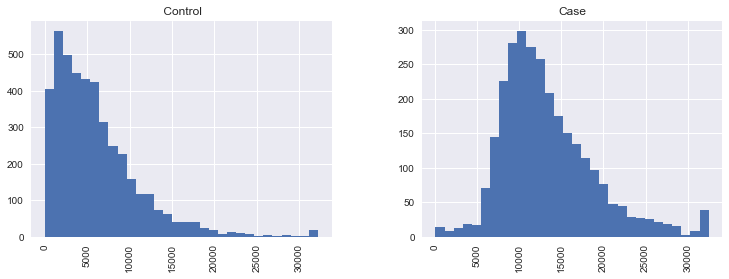

In [23]:
#Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_combined_working.sort_values(by='numCat', ascending=False)
df_combined_working.hist(column="length",by="numCat",bins=30, figsize=(12,4))

## The above shows that cases have more word counts.  Will superimpose the two histograms.

In [24]:
#superimposing histogram
df_contrl=df_combined_working.loc[df_combined_working['cases']==0,['ADMIT_DTTM','cases','length']]
df_case=df_combined_working.loc[df_combined_working['cases']==1,['ADMIT_DTTM','cases','length']]

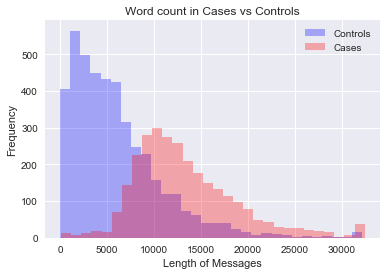

In [25]:
df_contrl['length'].plot(kind='hist', bins=30, alpha=.3,color='blue')
df_case['length'].plot(kind='hist', bins=30, alpha=.3,color='red')
plt.title('Word count in Cases vs Controls')
plt.legend(["Controls", "Cases"])
plt.xlabel('Length of Messages')
plt.show()

In [26]:
#CREATE LINEPLOT OVER TIME
df_dateIndex=df_combined_working.set_index('admit_monyr')

In [27]:
df_contrl_resample=df_contrl.resample('M',on='ADMIT_DTTM').mean()
df_case_resample=df_case.resample('M',on='ADMIT_DTTM').mean()

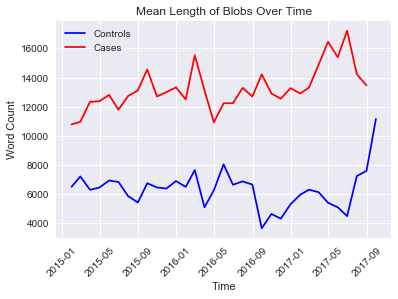

In [28]:
fig, ax= plt.subplots()
ax.plot(df_contrl_resample.length, color='b') #plot controls as blue
ax.plot(df_case_resample.length, color='r')   #plot cases as red
#ax.grid(b=False)

plt.xticks(rotation=45)

ax.set_title('Mean Length of Blobs Over Time')
ax.set_ylabel('Word Count')
ax.set_xlabel('Time')
ax.legend(["Controls", "Cases"])

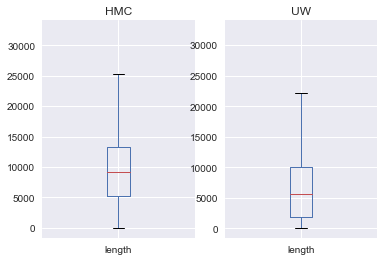

In [29]:
#CREATE BOXPLOT by CLINIC
fig, axes = plt.subplots(nrows=1, ncols=2)

# Generate a box plot of the fare prices for the First passenger class
df_combined_working.loc[df_combined_working['clinic'] =='HMC'].plot(ax=axes[0], y='length', kind='box',title='HMC')
df_combined_working.loc[df_combined_working['clinic'] == 'UW'].plot(ax=axes[1], y='length', kind='box',title='UW')
plt.show()

# C) INFERENTIAL STATISTICS
## SINCE THIS ANALYSIS IS BASED ON WORD PREDCITION, THE MAIN STATISTICS WILL COME IN A PREDICTION MODEL.
1. Determine basic statistics in word count between cases and controls
        a. Calculate 95% CI
2. Determine basic statistics in word count between clincis: HMC vs UW
        a. Calculate 95% CI
3. Parse data into a train- and test- dataset
4. Create a pipeline to do the following:
        a.Token and Vectorize blob content
            b.Calculate TFID
                c.Create a model using naive_bayes
5. Create a 'Classification Report'

In [30]:
#95%CI
def ci_i (ci,mean,n,std):
    """
    Input:
    Output: 2 tailed confidence interval (95% or 99%)
    Note: assumes only 100 DF
    """
    if ci==95:
        limit=1.984*(std/((n)**(.5)))
        return (mean-limit,mean+limit)
    elif ci==99:
        limit=2.626*(std/((n)**(.5)))
        return (mean-limit,mean+limit)
    else:
        print("Error")

In [31]:
grouped_data = df_combined_working.groupby(['numCat'])
grouped_data['length'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
numCat,,,,,,,,
Control,4327.0,6002.067714,4915.943072,2.0,2398.5,4878.0,8202.5,32185.0
Case,2853.0,13316.154224,5526.662584,90.0,9585.0,12203.0,16163.0,32462.0


In [32]:
l1,u1=ci_i(95,6056.628149,4327,4915.943072)
l2,u2=ci_i(95,13316.154224,2853,5526.662584)

print("The mean word count for the controls was 6,002.1 with  95%CI of ({:.1f},{:.1f})".format(l1, u1))
print("The mean word count for the cases was 13,316.2 with  95%CI of ({:.1f},{:.1f})".format(l2, u2))

The mean word count for the controls was 6,002.1 with  95%CI of (5908.4,6204.9)
The mean word count for the cases was 13,316.2 with  95%CI of (13110.9,13521.4)


In [33]:
grouped_data = df_combined_working.groupby(['clinic'])
grouped_data['length'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
clinic,,,,,,,,
HMC,4839.0,9949.673900,6306.327292,2.0,5170.5,9118.0,13242.5,32462.0
UW,2341.0,6755.857753,5666.446256,81.0,1884.0,5582.0,10022.0,32431.0


In [34]:
l1,u1=ci_i(95,9956.677413,4839,6311.111045)
l2,u2=ci_i(95,6759.706109,2341,5670.489293)

print("The mean word count for HMC was 9,956.7 with  95%CI of ({:.1f},{:.1f})".format(l1, u1))
print("The mean word count for UW was 6,759.7 with  95%CI of ({:.1f},{:.1f})".format(l2, u2))

The mean word count for HMC was 9,956.7 with  95%CI of (9776.7,10136.7)
The mean word count for UW was 6,759.7 with  95%CI of (6527.2,6992.2)


## SUMMARY: The non-overlapping 95% CI suggests that there is a significantdifference in mean word count between controls vs. cases, and between the clinics HMC vs UW.

In [35]:
pd.crosstab(df_combined_working.admit_year, df_combined_working.numCat, margins=True)

numCat,Control,Case,All
admit_year,,,
2015,1405,1059,2464
2016,1651,987,2638
2017,1271,807,2078
All,4327,2853,7180


In [36]:
pd.crosstab(df_combined_working.admit_year, df_combined_working.clinic, margins=True)

clinic,HMC,UW,All
admit_year,,,
2015,1836,628,2464
2016,1757,881,2638
2017,1246,832,2078
All,4839,2341,7180


# D.1) CUSTOMIZING STOPWORDS:
    1. Add any extra words to stopword dictionary

In [37]:
from nltk.corpus import stopwords
import string

In [38]:
#1. Adding new words to set called newWords, then append to library
stopwords=nltk.corpus.stopwords.words('english')
newWords=["idcc",'a','is']
stopwords.extend(newWords)

# D.2) CREATE A TRAIN AND TEST DATASET

In [39]:
from sklearn.cross_validation import train_test_split

C:\Users\arao2\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
msg_train, msg_test, label_train, label_test = \
train_test_split(df_combined_working['blob_string'], df_combined_working['cases'], test_size=0.3)

# D.3) CREATE A PIPELINE

In [41]:
#TEXT_PROCESS
def text_process(mess):
    """
    1. remove punctuation
    2. remove stopwords
    3. return list of clean text words
    """

    nopunc=[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords]

In [42]:
#COUNTVECTORIZER
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
#TFIDTRANSFORMER
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
#MULTINOMIALNB
from sklearn.naive_bayes import MultinomialNB

In [50]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [46]:
pipeline.fit(msg_train,label_train)
predictions=pipeline.predict(msg_test)

In [47]:
from sklearn.metrics import classification_report
print (classification_report(label_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97      1294
          1       0.92      0.99      0.96       860

avg / total       0.97      0.96      0.96      2154



# E. NEED TO DO
## Repeat using another model such as random-forest model
## Which were the top words/phrases
## Assess how well the listed words phrases did

In [51]:
#RANDOMFOREST
from sklearn.ensemble import RandomForestClassifier
pipeline_randfor = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [52]:
pipeline_randfor.fit(msg_train,label_train)
predictions_randfor=pipeline_randfor.predict(msg_test)
print (classification_report(label_test,predictions_randfor))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1294
          1       1.00      0.99      0.99       860

avg / total       0.99      0.99      0.99      2154



## Random forest model produced a better prediction model than the multnomial Naive Bayes

# WHATE WERE THE TOP 10 WORDS

# ASSESSING THE GIVEN LIST